In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.feature_selection import RFE
import shap
import warnings
warnings.filterwarnings("ignore")

In [2]:
def check_duplicates(data):
    # Duplicated rows
    duplicates = data.duplicated().sum()
    print('Number of duplicate rows = %d' % (duplicates))


def check_missing_values(data):
    # make a list of the variables that contain missing values
    vars_with_na = [var for var in data.columns if data[var].isnull().sum()>1]

    # print the variable name and the percentage of missing values
    for var in vars_with_na:
        print(var, np.round(data[var].isnull().mean(), 3),  ' % missing values')
        
def plot_feature(data, feature_name):
    feature = sorted(data[feature_name])
    idx = []
    for i in range(len(feature)):
        idx.append(i)
    x = idx
    y = feature
    
    plt.figure(figsize=(15,12))
    plt.scatter(x, y, s=10)
    
        
def create_boxplots(data, features, target):
    plt.figure(figsize=(25, 25))
    for i in range(len(features)):
        plt.subplot(5, 5, i+1)
        sns.boxplot(x=target, y=features[i], data=data)
        
def create_distplots(data, features):
    plt.figure(figsize=(20, 20))
    for i in range(len(features)):
        plt.subplot(5, 5, i+1)
        sns.distplot(data[features[i]], kde=False)
        
def plot_heatmap(data, numeric_vars):
    """
    Creates heatmap with linear correlations among variables.
    
    Function first takes copy of passed dataframe and encodes categorical variables with average salary for given category.
    
    Parameters
    ----------
    data : DataFrame
    numeric_vars : array
    cat_vars: array
    
    """
        
    df = data.copy()
    
    # Correlations between selected features and response
    fig = plt.figure(figsize=(12, 10))
    ax = sns.heatmap(df[numeric_vars + ['Loan_Status']].corr(), cmap='Blues', annot=True)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.title('Linear relationships', size = 20)
    plt.show()   
    
    fig = plt.figure(figsize=(12, 10))
    plt.title('Monotonic relationships', size = 20)
    ax = sns.heatmap(df[numeric_vars + ['Loan_Status']].corr('spearman'), cmap='Blues', annot=True)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()  
    

    

def plot_categorical_heatmap(data, col1, col2):
    df_gp = data[[col1,col2,'Loan_Status']]
    grouped_df = df_gp.groupby([col1,col2],as_index=False).mean()
    grouped_pivot = grouped_df.pivot(index=col1,columns=col2)
    #fill missing values with 0
    grouped_pivot = grouped_pivot.fillna(0)
    
    fig, ax = plt.subplots()
    im = ax.pcolor(grouped_pivot, cmap='coolwarm')

    #label names
    row_labels = grouped_pivot.columns.levels[1]
    col_labels = grouped_pivot.index

    #move ticks and labels to the center
    ax.set_xticks(np.arange(grouped_pivot.shape[1]) + 0.5, minor=False)
    ax.set_yticks(np.arange(grouped_pivot.shape[0]) + 0.5, minor=False)
    
    #insert labels
    ax.set_xticklabels(row_labels, minor=False)
    ax.set_yticklabels(col_labels, minor=False)

    #rotate label if too long
    plt.xticks(rotation=90)

    fig.colorbar(im)
    
def plot_feature_importance_tree(dt, X):
    importances = dt.feature_importances_
    feature_importances = pd.DataFrame({'Feature':X.columns, 'Importance':importances})
    feature_importances.sort_values(by='Importance', ascending=False, inplace=True)
    plt.figure(figsize = (10,6))
    plt.xticks(rotation=45)
    plt.title('Feature importance obtain by Decision Tree Regressor', size = 20)
    plt.xlabel('Feature', fontsize = 15)
    plt.ylabel('Importance', fontsize = 15)
    sns.barplot(x='Feature', y='Importance', data = feature_importances)
    plt.show()

In [3]:
data  = pd.read_csv("https://raw.githubusercontent.com/dphi-official/Datasets/master/Loan_Data/loan_train.csv", index_col = 0)
data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP002305,Female,No,0,Graduate,No,4547,0.0,115.0,360.0,1.0,Semiurban,1
1,LP001715,Male,Yes,3+,Not Graduate,Yes,5703,0.0,130.0,360.0,1.0,Rural,1
2,LP002086,Female,Yes,0,Graduate,No,4333,2451.0,110.0,360.0,1.0,Urban,0
3,LP001136,Male,Yes,0,Not Graduate,Yes,4695,0.0,96.0,NaN,1.0,Urban,1
4,LP002529,Male,Yes,2,Graduate,No,6700,1750.0,230.0,300.0,1.0,Semiurban,1


In [4]:
data.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status
count,491.000000,491.000000,475.000000,478.000000,448.000000,491.000000
mean,5401.189409,1589.730998,145.014737,341.297071,0.848214,0.698574
std,6419.427177,2919.320624,86.310534,66.964051,0.359214,0.459345
min,150.000000,0.000000,17.000000,12.000000,0.000000,0.000000
25%,2923.500000,0.000000,100.000000,360.000000,1.000000,0.000000
50%,3865.000000,1229.000000,126.000000,360.000000,1.000000,1.000000
75%,5705.500000,2251.500000,162.000000,360.000000,1.000000,1.000000
max,81000.000000,41667.000000,700.000000,480.000000,1.000000,1.000000


In [5]:
# making sure each column has expected datatype
data.dtypes

Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status            int64
dtype: object

In [6]:
# check number of missing values
check_missing_values(data)

Gender 0.02  % missing values
Dependents 0.018  % missing values
Self_Employed 0.059  % missing values
LoanAmount 0.033  % missing values
Loan_Amount_Term 0.026  % missing values
Credit_History 0.088  % missing values


In [7]:
check_duplicates(data)

Number of duplicate rows = 0


In [8]:
for feature in ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']:
    print(feature, ' : ', data[feature].unique())

Gender  :  ['Female' 'Male' nan]
Married  :  ['No' 'Yes' nan]
Dependents  :  ['0' '3+' '2' '1' nan]
Education  :  ['Graduate' 'Not Graduate']
Self_Employed  :  ['No' 'Yes' nan]
Property_Area  :  ['Semiurban' 'Rural' 'Urban']


In [9]:
data.Married.unique()

array(['No', 'Yes', nan], dtype=object)

In [10]:
data.Gender.replace('Male', 1, inplace = True)
data.Gender.replace('Female', 0, inplace = True)
data.Property_Area.replace('Rural', 1, inplace = True)
data.Property_Area.replace('Semiurban', 2, inplace = True)
data.Property_Area.replace('Urban', 3, inplace = True)
data.Married.replace('Yes', 1, inplace = True)
data.Married.replace('No', 0, inplace = True)
data.Self_Employed.replace('Yes', 1, inplace = True)
data.Self_Employed.replace('No', 0, inplace = True)
data.Education.replace('Graduate', 1, inplace = True)
data.Education.replace('Not Graduate', 0, inplace = True)
data.Dependents.replace('3+', 3, inplace = True)

In [11]:
for feature in ['Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']:
    print(feature, ' : ', data[feature].unique())

Married  :  [ 0.  1. nan]
Dependents  :  ['0' 3 '2' '1' nan]
Education  :  [1 0]
Self_Employed  :  [ 0.  1. nan]
Property_Area  :  [2 1 3]


In [12]:
for feature in ['Gender', 'Married', 'Dependents', 'Self_Employed', 'Credit_History']:
    if feature == 'Credit_History':
        data[feature].fillna(0, inplace = True)
    else:
        print(feature)
        print(data[feature].mode())
        data[feature].fillna(data[feature].mode().values[0], inplace = True)

Gender
0    1.0
dtype: float64
Married
0    1.0
dtype: float64
Dependents
0    0
dtype: object
Self_Employed
0    0.0
dtype: float64


In [13]:
# check number of missing values
check_missing_values(data)

LoanAmount 0.033  % missing values
Loan_Amount_Term 0.026  % missing values


In [14]:
for feature in ['LoanAmount', 'Loan_Amount_Term']:
    data[feature].fillna(data[feature].median(), inplace = True)

In [15]:
# check number of missing values
check_missing_values(data)

In [16]:
for feature in ['Gender', 'Married', 'Dependents', 'Self_Employed']:
    data[feature] = data[feature].astype(float)

In [17]:
data.describe()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
count,491.000000,491.000000,491.000000,491.000000,491.000000,491.000000,491.000000,491.000000,491.000000,491.000000,491.000000,491.000000
mean,0.820774,0.661914,0.753564,0.790224,0.130346,5401.189409,1589.730998,144.395112,341.792261,0.773931,2.010183,0.698574
std,0.383933,0.473540,1.015373,0.407564,0.337027,6419.427177,2919.320624,84.956932,66.138118,0.418711,0.788889,0.459345
min,0.000000,0.000000,0.000000,0.000000,0.000000,150.000000,0.000000,17.000000,12.000000,0.000000,1.000000,0.000000
25%,1.000000,0.000000,0.000000,1.000000,0.000000,2923.500000,0.000000,100.000000,360.000000,1.000000,1.000000,0.000000
50%,1.000000,1.000000,0.000000,1.000000,0.000000,3865.000000,1229.000000,126.000000,360.000000,1.000000,2.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000,0.000000,5705.500000,2251.500000,160.000000,360.000000,1.000000,3.000000,1.000000
max,1.000000,1.000000,3.000000,1.000000,1.000000,81000.000000,41667.000000,700.000000,480.000000,1.000000,3.000000,1.000000


Loan_Status
0    148
1    343
dtype: int64


<AxesSubplot:xlabel='Loan_Status'>

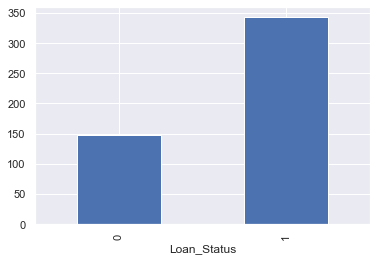

In [18]:
# checking Loan_Status distribution
counts = data.groupby('Loan_Status').size()
print(counts)
counts.plot(kind = 'bar')

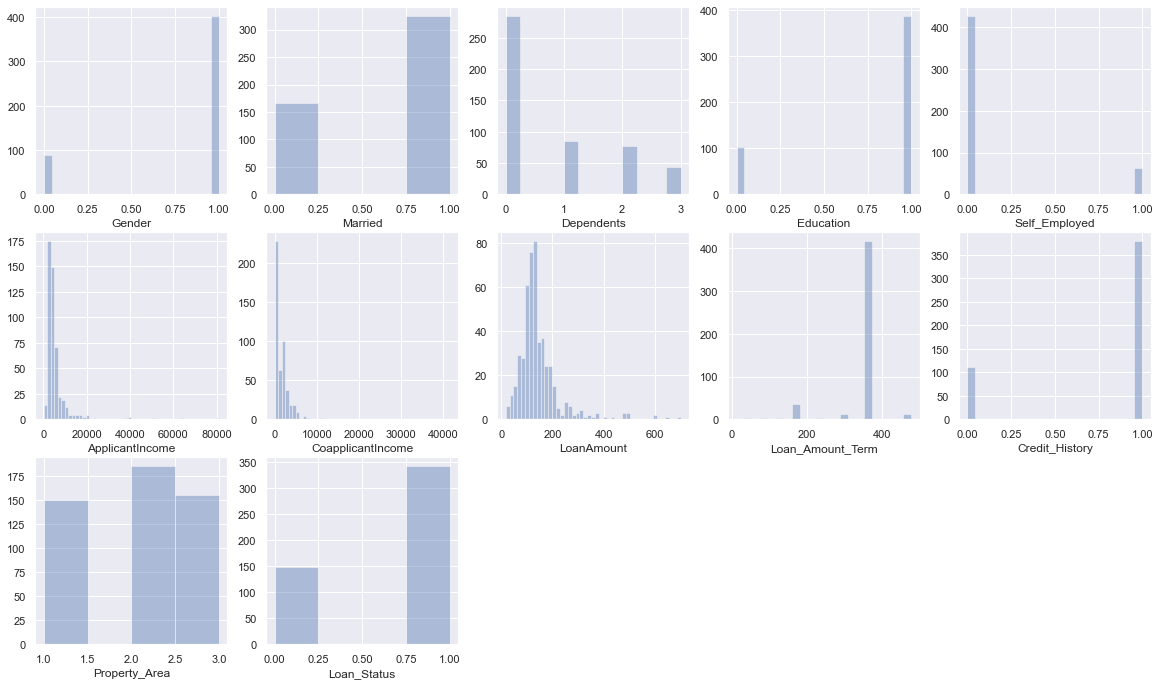

In [19]:
num_vars = list(data.select_dtypes(exclude=['object', 'category']).columns)

# creating distribution plots
create_distplots(data, num_vars)

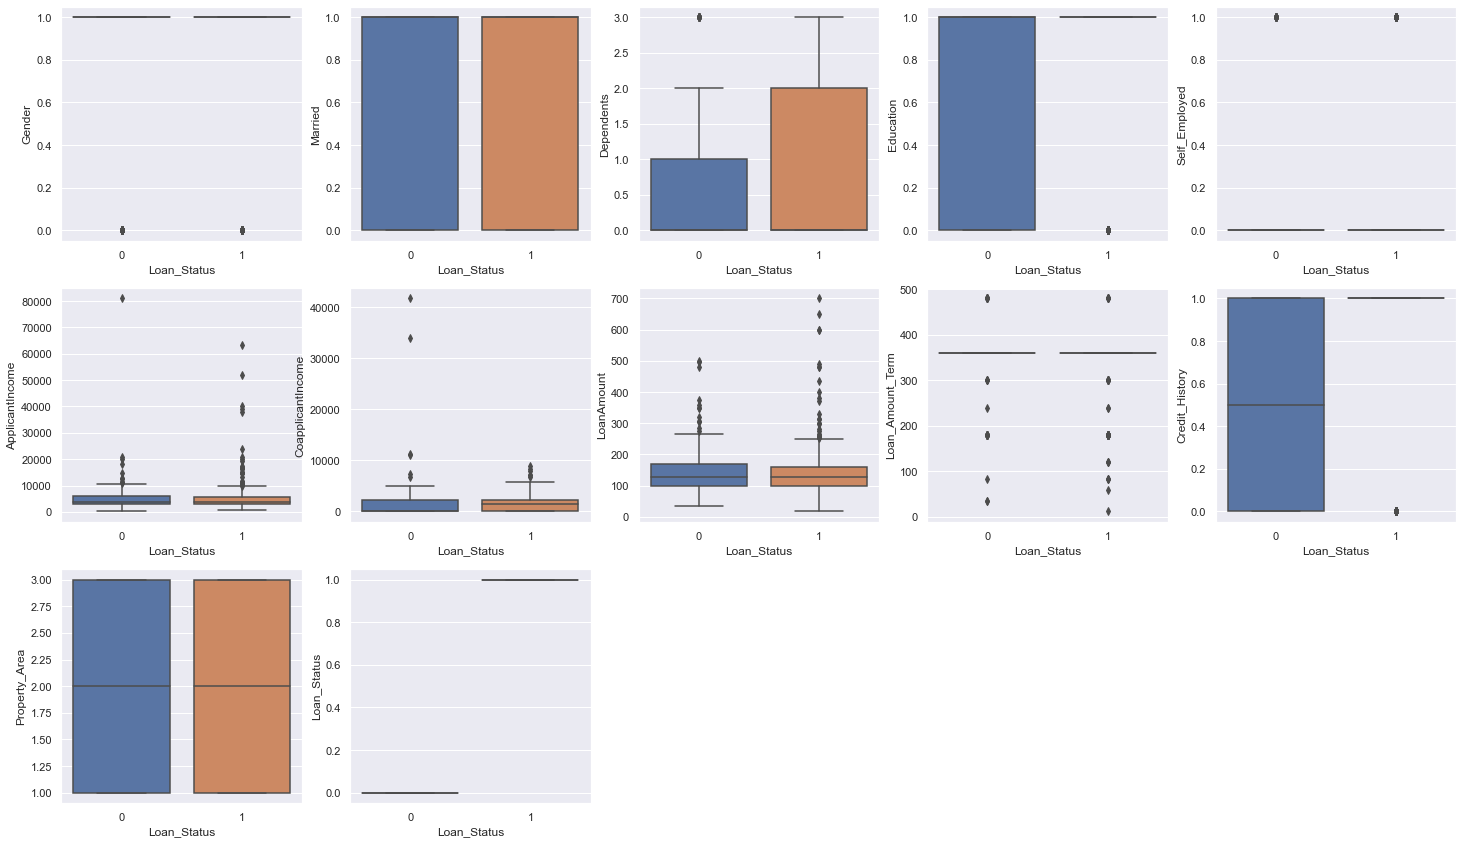

In [20]:
create_boxplots(data, features = num_vars, target = 'Loan_Status')

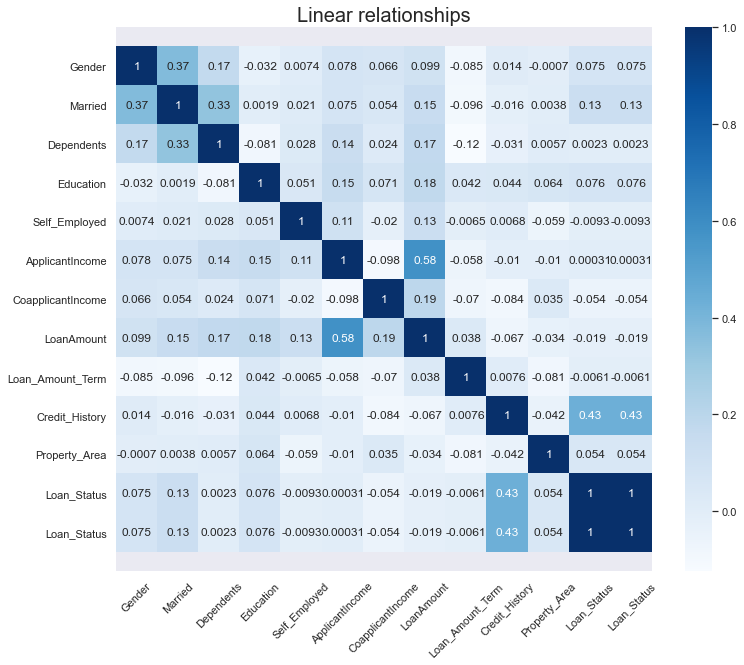

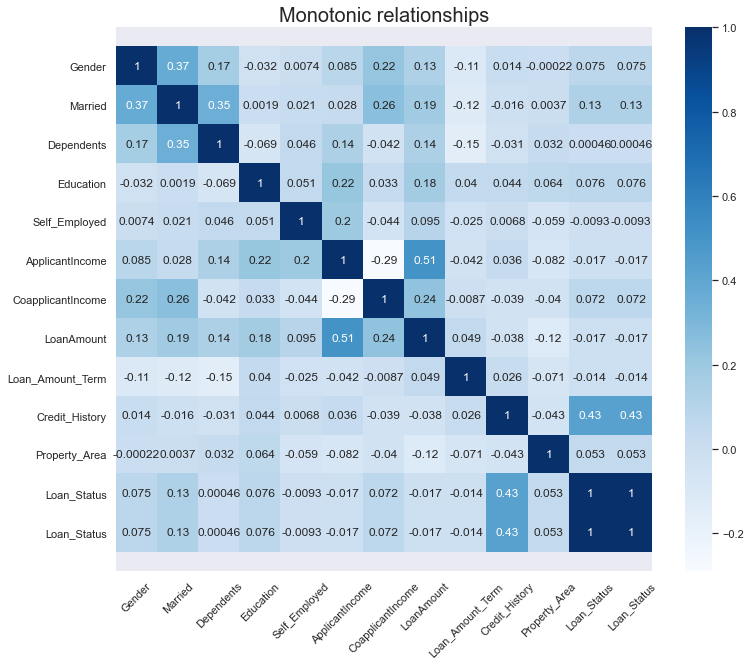

In [21]:
plot_heatmap(data, numeric_vars = num_vars)

In [22]:
data.drop('Loan_ID', axis = 1, inplace = True)

In [23]:
X = data.drop('Loan_Status', axis = 1)
y = data[['Loan_Status']]

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

In [25]:
lr = Pipeline([('scaler', StandardScaler()), 
               ('smt', SMOTE(random_state=42)),
                        ('LogisticRegression', LogisticRegression())])

In [26]:
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
y_pred_train = lr.predict(X_train)

# Calculating the accuracy and F1 Score by comparing the actual and predicted values
ac = accuracy_score(y_test, y_pred)
f_score = f1_score(y_test ,y_pred)

ac_train = accuracy_score(y_train, y_pred_train)
f_score_train = f1_score(y_train ,y_pred_train)

print("Baseline Model Accuracy:", ac)
print("Baseline Model F1 Score: Test", f_score)

print("Baseline Model Accuracy:", ac_train)
print("Baseline Model F1 Score Train:", f_score_train)

Baseline Model Accuracy: 0.6767676767676768
Baseline Model F1 Score: Test 0.7538461538461539
Baseline Model Accuracy: 0.7372448979591837
Baseline Model F1 Score Train: 0.8089053803339518


In [27]:
  # Random Forest hyperparameters
rf_hyperparameters = {
    'RandomForestClassifier__n_estimators': [40, 50, 80, 100],
    'RandomForestClassifier__max_features': ['auto', 6, 7, 8, 9],
    'RandomForestClassifier__max_depth': [3,4,5,6,7,8, 9],
    'RandomForestClassifier__min_samples_leaf': [5, 10, 13, 17]
    
}

# Boosted Tree hyperparameters
gb_hyperparameters = {
    'GradientBoostingClassifier__n_estimators': [10, 20, 30, 40, 50],
    'GradientBoostingClassifier__learning_rate': [ 0.5, 0.4, 0.2, 0.25, 0.3],
    'GradientBoostingClassifier__max_depth': [2, 3, 4, 5,6,7]
}

# XGBoost hyperparameters
xgb_hyperparameters = {
    'XGB__n_estimators': [40, 50, 60, 70],
    'XGB__learning_rate': [ 0.5, 0.4, 0.3, 0.2],
    'XGB__max_depth': [ 3, 4, 5, 6]
}

### Random Forest

In [109]:
rf = Pipeline([('smt', SMOTE(random_state=42)),
                        ('RandomForestClassifier', RandomForestClassifier(random_state = 0, max_depth = 3))])

In [110]:
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_pred_train = rf.predict(X_train)

# Calculating the accuracy and F1 Score by comparing the actual and predicted values
ac = accuracy_score(y_test, y_pred)
f_score = f1_score(y_test ,y_pred)

ac_train = accuracy_score(y_train, y_pred_train)
f_score_train = f1_score(y_train ,y_pred_train)

print("Baseline Model Accuracy:", ac)
print("Baseline Model F1 Score: Test", f_score)

print("Baseline Model Accuracy:", ac_train)
print("Baseline Model F1 Score Train:", f_score_train)

Baseline Model Accuracy: 0.7575757575757576
Baseline Model F1 Score: Test 0.8285714285714285
Baseline Model Accuracy: 0.7959183673469388
Baseline Model F1 Score Train: 0.8606271777003485


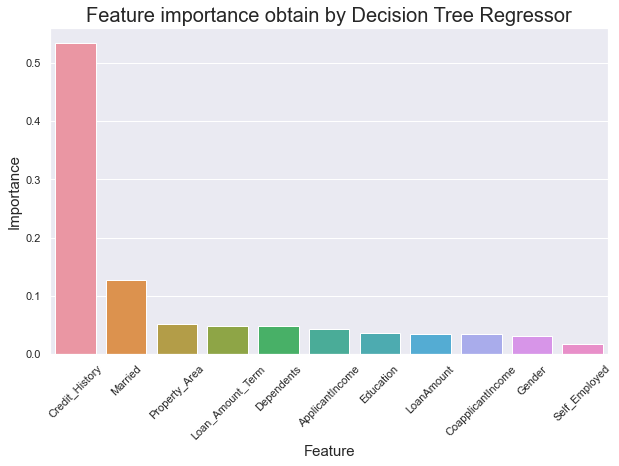

In [111]:
plot_feature_importance_tree(rf.named_steps.RandomForestClassifier, X_train)

In [112]:
#selected_X = ['Credit_History', 'Married', 'Property_Area', 'Gender', 'CoapplicantIncome', 'Dependents', 'ApplicantIncome', 'LoanAmount', 'Education', 'Loan_Amount_Term']
# selected_X = ['Credit_History', 'Married', 'Property_Area', 'Loan_Amount_Term', 'Dependents', 'ApplicantIncome']
# selected_X = ['Credit_History', 'Married_Yes', 'Property_Area_Semiurban', 'Dependents_2', 'Education_Graduate', 'Loan_Amount_Term', 'CoapplicantIncome', 'Gender_Male', 'ApplicantIncome']
selected_X = X.columns
X_train[selected_X]

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
188,0.0,1.0,1.0,1,0.0,3326,913.0,105.0,84.0,1.0,2
425,1.0,0.0,0.0,1,0.0,1916,5063.0,67.0,360.0,0.0,1
459,1.0,1.0,2.0,1,1.0,3316,3500.0,88.0,360.0,1.0,3
154,0.0,0.0,0.0,1,1.0,4583,0.0,133.0,360.0,0.0,2
484,1.0,1.0,1.0,1,0.0,1538,1425.0,30.0,360.0,1.0,3
...,...,...,...,...,...,...,...,...,...,...,...
323,1.0,1.0,0.0,1,0.0,3941,2336.0,134.0,360.0,1.0,2
192,1.0,0.0,0.0,0,0.0,3975,2531.0,55.0,360.0,1.0,1
117,1.0,1.0,0.0,1,0.0,9323,0.0,75.0,180.0,1.0,3
47,1.0,1.0,1.0,1,0.0,1625,1803.0,96.0,360.0,1.0,3


In [113]:
rf.fit(X_train[selected_X], y_train)
y_pred = rf.predict(X_test[selected_X])
y_pred_train = rf.predict(X_train[selected_X])

# Calculating the accuracy and F1 Score by comparing the actual and predicted values
ac = accuracy_score(y_test, y_pred)
f_score = f1_score(y_test ,y_pred)

ac_train = accuracy_score(y_train, y_pred_train)
f_score_train = f1_score(y_train ,y_pred_train)

print("Baseline Model Accuracy:", ac)
print("Baseline Model F1 Score: Test", f_score)

print("Baseline Model Accuracy:", ac_train)
print("Baseline Model F1 Score Train:", f_score_train)

Baseline Model Accuracy: 0.7575757575757576
Baseline Model F1 Score: Test 0.8285714285714285
Baseline Model Accuracy: 0.7959183673469388
Baseline Model F1 Score Train: 0.8606271777003485


In [114]:
#search = GridSearchCV(estimator = rf,
#                                   param_grid = rf_hyperparameters,
#                                   scoring = 'f1',
#                                   cv = 10)
##search.fit(X_important_train, y_train.values.ravel())
#search.fit(X_train[selected_X], y_train.values.ravel())

In [115]:
#search.best_params_

In [116]:
rf = Pipeline([('smt', SMOTE(random_state=42)),
                        ('RandomForestClassifier', RandomForestClassifier(random_state = 0, max_depth = 3,  max_features = 9, min_samples_leaf = 5, n_estimators = 80))])

In [117]:
rf.fit(X_train[selected_X], y_train)
y_pred = rf.predict(X_test[selected_X])
y_pred_train = rf.predict(X_train[selected_X])

# Calculating the accuracy and F1 Score by comparing the actual and predicted values
ac = accuracy_score(y_test, y_pred)
f_score = f1_score(y_test ,y_pred)

ac_train = accuracy_score(y_train, y_pred_train)
f_score_train = f1_score(y_train ,y_pred_train)

print("Baseline Model Accuracy:", ac)
print("Baseline Model F1 Score: Test", f_score)

print("Baseline Model Accuracy:", ac_train)
print("Baseline Model F1 Score Train:", f_score_train)

Baseline Model Accuracy: 0.7474747474747475
Baseline Model F1 Score: Test 0.8226950354609929
Baseline Model Accuracy: 0.7831632653061225
Baseline Model F1 Score Train: 0.8537005163511188


### XGBoost

In [101]:
xgb = Pipeline([('smt', SMOTE(random_state=42)),
                        ('XGB', XGBClassifier(random_state = 0, max_depth = 4))])

In [102]:
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
y_pred_train = xgb.predict(X_train)

# Calculating the accuracy and F1 Score by comparing the actual and predicted values
ac = accuracy_score(y_test, y_pred)
f_score = f1_score(y_test ,y_pred)

ac_train = accuracy_score(y_train, y_pred_train)
f_score_train = f1_score(y_train ,y_pred_train)

print("Baseline Model Accuracy:", ac)
print("Baseline Model F1 Score: Test", f_score)

print("Baseline Model Accuracy:", ac_train)
print("Baseline Model F1 Score Train:", f_score_train)

[10:15:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Baseline Model Accuracy: 0.696969696969697
Baseline Model F1 Score: Test 0.7857142857142858
Baseline Model Accuracy: 0.9974489795918368
Baseline Model F1 Score Train: 0.9981981981981982


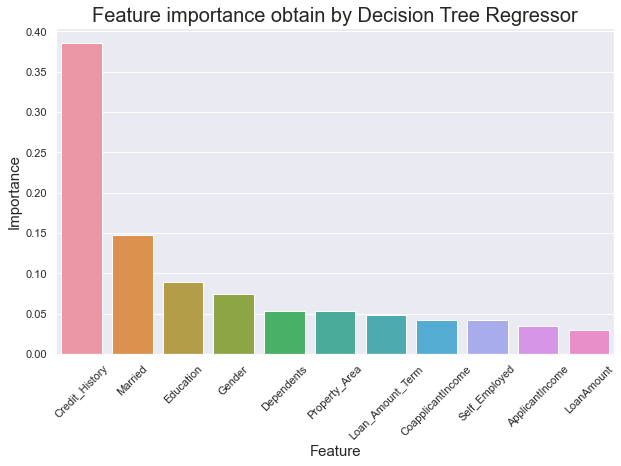

In [103]:
plot_feature_importance_tree(xgb.named_steps.XGB, X_train)

In [104]:
selected_X = ['Credit_History', 'Married', 'Gender', 'Education', 'Dependents', 'CoapplicantIncome', 'Loan_Amount_Term', 'Property_Area', 'ApplicantIncome', 'LoanAmount']

In [105]:
#search = GridSearchCV(estimator = xgb,
#                                   param_grid = xgb_hyperparameters,
#                                   scoring = 'f1',
#                                   cv = 10)
#search.fit(X_train[selected_X], y_train.values.ravel())

In [106]:
#search.best_params_

In [107]:
xgb = Pipeline([('smt', SMOTE(random_state=42)),
                        ('XGB', XGBClassifier(random_state = 0, learning_rate = 0.2, max_depth = 4 , n_estimators = 50))])

In [108]:
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
y_pred_train = xgb.predict(X_train)

# Calculating the accuracy and F1 Score by comparing the actual and predicted values
ac = accuracy_score(y_test, y_pred)
f_score = f1_score(y_test ,y_pred)

ac_train = accuracy_score(y_train, y_pred_train)
f_score_train = f1_score(y_train ,y_pred_train)

print("Baseline Model Accuracy:", ac)
print("Baseline Model F1 Score: Test", f_score)

print("Baseline Model Accuracy:", ac_train)
print("Baseline Model F1 Score Train:", f_score_train)

[10:15:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Baseline Model Accuracy: 0.7272727272727273
Baseline Model F1 Score: Test 0.8085106382978724
Baseline Model Accuracy: 0.9209183673469388
Baseline Model F1 Score Train: 0.9460869565217391


## Fitting the picked model (Random Forest) on the whole dataset

In [118]:
rf.fit(X, y)
y_pred = rf.predict(X)
y_pred_train = rf.predict(X)

# Calculating the accuracy and F1 Score by comparing the actual and predicted values
ac = accuracy_score(y, y_pred)
f_score = f1_score(y ,y_pred)

ac_train = accuracy_score(y, y_pred_train)
f_score_train = f1_score(y ,y_pred_train)

print("Baseline Model Accuracy:", ac)
print("Baseline Model F1 Score: Test", f_score)

print("Baseline Model Accuracy:", ac_train)
print("Baseline Model F1 Score Train:", f_score_train)

Baseline Model Accuracy: 0.7739307535641547
Baseline Model F1 Score: Test 0.8464730290456431
Baseline Model Accuracy: 0.7739307535641547
Baseline Model F1 Score Train: 0.8464730290456431


### UNSEEN DATA

In [171]:
test_new = pd.read_csv('https://raw.githubusercontent.com/dphi-official/Datasets/master/Loan_Data/loan_test.csv')

In [172]:
test_new.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001116,Male,No,0,Not Graduate,No,3748,1668.0,110.0,360.0,1.0,Semiurban
1,LP001488,Male,Yes,3+,Graduate,No,4000,7750.0,290.0,360.0,1.0,Semiurban
2,LP002138,Male,Yes,0,Graduate,No,2625,6250.0,187.0,360.0,1.0,Rural
3,LP002284,Male,No,0,Not Graduate,No,3902,1666.0,109.0,360.0,1.0,Rural
4,LP002328,Male,Yes,0,Not Graduate,No,6096,0.0,218.0,360.0,0.0,Rural


In [173]:
check_missing_values(test_new)

Gender 0.024  % missing values
Married 0.016  % missing values
Dependents 0.049  % missing values
Self_Employed 0.024  % missing values
LoanAmount 0.049  % missing values
Credit_History 0.057  % missing values


In [174]:
for feature in ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']:
    print(feature, ' : ', test_new[feature].unique())

Gender  :  ['Male' 'Female' nan]
Married  :  ['No' 'Yes' nan]
Dependents  :  ['0' '3+' '2' '1' nan]
Education  :  ['Not Graduate' 'Graduate']
Self_Employed  :  ['No' 'Yes' nan]
Property_Area  :  ['Semiurban' 'Rural' 'Urban']


In [175]:
test_new.Gender.replace('Male', 1, inplace = True)
test_new.Gender.replace('Female', 0, inplace = True)
test_new.Property_Area.replace('Rural', 1, inplace = True)
test_new.Property_Area.replace('Semiurban', 2, inplace = True)
test_new.Property_Area.replace('Urban', 3, inplace = True)
test_new.Married.replace('Yes', 1, inplace = True)
test_new.Married.replace('No', 0, inplace = True)
test_new.Self_Employed  .replace('Yes', 1, inplace = True)
test_new.Self_Employed  .replace('No', 0, inplace = True)
test_new.Education.replace('Graduate', 1, inplace = True)
test_new.Education.replace('Not Graduate', 0, inplace = True)
test_new.Dependents.replace('3+', 3, inplace = True)

In [176]:
for feature in ['Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']:
    print(feature, ' : ', test_new[feature].unique())

Married  :  [ 0.  1. nan]
Dependents  :  ['0' 3 '2' '1' nan]
Education  :  [0 1]
Self_Employed  :  [ 0.  1. nan]
Property_Area  :  [2 1 3]


In [177]:
for feature in ['Gender', 'Married', 'Dependents', 'Self_Employed', 'Credit_History']:
    if feature == 'Credit_History':
        test_new[feature].fillna(0, inplace = True)
    else:
        print(feature)
        print(test_new[feature].mode())
        test_new[feature].fillna(test_new[feature].mode().values[0], inplace = True)

Gender
0    1.0
dtype: float64
Married
0    1.0
dtype: float64
Dependents
0    0
dtype: object
Self_Employed
0    0.0
dtype: float64


In [178]:
# check number of missing values
check_missing_values(test_new)

LoanAmount 0.049  % missing values


In [179]:
for feature in ['LoanAmount', 'Loan_Amount_Term']:
    (test_new)[feature].fillna((test_new)[feature].median(), inplace = True)

In [180]:
# check number of missing values
check_missing_values(test_new)

In [181]:
for feature in ['Gender', 'Married', 'Dependents', 'Self_Employed']:
    test_new[feature] = test_new[feature].astype(float)

In [182]:
test_new.drop('Loan_ID', axis = 1, inplace = True)

In [183]:
test_new.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,1.0,0.0,0.0,0,0.0,3748,1668.0,110.0,360.0,1.0,2
1,1.0,1.0,3.0,1,0.0,4000,7750.0,290.0,360.0,1.0,2
2,1.0,1.0,0.0,1,0.0,2625,6250.0,187.0,360.0,1.0,1
3,1.0,0.0,0.0,0,0.0,3902,1666.0,109.0,360.0,1.0,1
4,1.0,1.0,0.0,0,0.0,6096,0.0,218.0,360.0,0.0,1


In [185]:
# Unseen data predictions
y_pred_new = rf.predict(test_new)
y_pred_new

array([1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1], dtype=int64)

In [186]:
y_pred_new.reshape(1,-1).astype(int)
res = pd.DataFrame(y_pred_new).astype(int)
res.index = test_new.index
res.columns=['prediction']
res.to_csv('predicted.csv', index=False)

In [187]:
y_pred_new

array([1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1], dtype=int64)

### Saving the artifacts

In [219]:
import json
columns = {
    'data_columns' : [col.lower() for col in X.columns]
}
with open ('columns.json', 'w') as f:
    f.write(json.dumps(columns))

In [220]:
import pickle
with open('loans_model.pickle', 'wb') as f:
    pickle.dump(rf, f)

### Double checking the model was saved correctly

In [99]:
import pickle
model = pickle.load(open('loans_model.pickle', 'rb'))

In [100]:
model

Pipeline(steps=[('smt', SMOTE(random_state=42)),
                ('RandomForestClassifier',
                 RandomForestClassifier(max_depth=3, max_features=9,
                                        min_samples_leaf=5, n_estimators=80,
                                        random_state=0))])